# Implementation of Quantum Circuit Learning

(following QuLacs tutorial in https://docs.qulacs.org/en/latest/apply/5.2_qcl.html)

Fitting of a sin function $y=sin(\pi x)$

In [101]:
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
from qulacs import QuantumState, QuantumCircuit
from qulacsvis import circuit_drawer


In [102]:
########  Parameter  #############
nqubit = 3 ## number of qubit
c_depth = 3 ## depth of circuit
time_step = 0.75 ## elapsed time of time evolution with random Hamiltonian

## randomly take num_x_train points from [x_min, x_max] as teacher data.
x_min = - 1.; x_max = 1.
num_x_train = 100

## one variable function to learn
func_to_learn = lambda x: np.cos(x*np.pi)

## seed of random number
random_seed = 0
## initialization of random number generator
np.random.seed(random_seed)

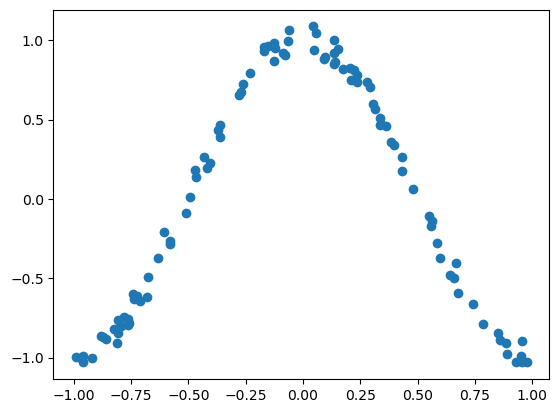

In [103]:
#### Prepare teacher data
x_train = x_min + (x_max - x_min) * np.random.rand(num_x_train)
y_train = func_to_learn(x_train)

# Add noise to pure sine function assuming real data used
mag_noise = 0.05
y_train = y_train + mag_noise * np.random.randn(num_x_train)

plt.plot(x_train, y_train, "o"); plt.show()

In [104]:
# Initial State
state = QuantumState(nqubit) # Initial state |000>
state.set_zero_state()
print(state.get_vector())

[1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]


We create the gate $U_{in}(x_i)$ for embedding the input value $x_i$ in the initial state $\ket{00...0}$. According to reference $[1]$ we define:
$U_{in}(x_i) = $
with rotation gates
$R^Y_j$

So input $x_i$, is converted into: $\ket{\psi_{in}(x_i)} = U_{in}(x_i)\ket{00...0}$


In [105]:
# Function that creats a gate encoding x
def U_in(x):
    U = QuantumCircuit(nqubit)

    angle_y = np.arcsin(x)
    angle_z = np.arccos(x**2)

    for i in range(nqubit):
        U.add_RY_gate(i, angle_y)
        U.add_RZ_gate(i, angle_z)

    return U

[-6.93804351e-01+7.14937415e-01j -3.54871219e-02-3.51340074e-02j
 -3.54871219e-02-3.51340074e-02j  1.77881430e-03-1.76111422e-03j
 -3.54871219e-02-3.51340074e-02j  1.77881430e-03-1.76111422e-03j
  1.77881430e-03-1.76111422e-03j  8.73809020e-05+9.00424970e-05j]


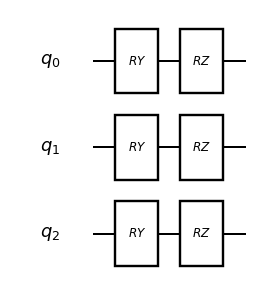

In [106]:
# Test initial state
x = 0.1 # appropriate value
U_in(x).update_quantum_state(state) # calculation of U_in|000>
print(state.get_vector())

circuit_drawer(U_in(x),'mpl')


### Construct variational quantum circuit $U(\theta)$

Next, a variational quantum circuit $U(\theta)$ to be optimized is created. The procedure is the following three steps: 
1. Create a transverse magnetic field Ising Hamiltonian. 
2. Create rotation gates. 
3. Combine step1 and step2’s gates alternatively to make a large variational quantum circuit $U(\theta)$.

### 1. Creating a transverse magnetic field Ising Hamiltonian

The Hamiltonian of transverse magnetic field Ising model is given by:

$H = \sum\limits^N_{j=1} a_j X_j + \sum\limits^N_{j=1}\sum\limits^{j-1}_{k=1} J_{jk}Z_jZ_k$

Coefficients $a, J$ are taken from a random uniform distribution in $[-1,1]$

To define the Ising Hamiltonian we first define the X and Z gates. 

The ```make_fullgate``` function is then used to create a full-size gate for a quantum system with a specified number of qubits. The function takes two arguments: ```list_SiteAndOperator``` and ```nqubit```.

```list_SiteAndOperator``` is a list of lists, where each inner list contains two elements: a site (or qubit index) and an operator (or gate) that should be applied to that site. For example, ```[[i_0, O_0], [i_1, O_1], ...]``` means that operator ```O_0``` should be applied to qubit ```i_0```, operator ```O_1``` to qubit ```i_1```, and so on.

```nqubit``` is the total number of qubits in the system.

The function first extracts the list of sites from ```list_SiteAndOperator``` and initializes an empty list ```list_SingleGates``` to store the gates for each qubit.

Then, it iterates over the range of nqubit. For each qubit index i, if i is in the list of sites, it appends the corresponding operator from ```list_SiteAndOperator``` to ```list_SingleGates```. If i is not in the list of sites (meaning no specific operator is to be applied to this qubit), it appends an identity matrix ```I_mat``` to ```list_SingleGates```. The identity matrix represents a gate that leaves the state of a qubit unchanged.

Finally, the function uses the reduce function from Python's functools module with ```np.kron``` (Kronecker product) as the binary function to combine all the single-qubit gates in list_SingleGates into a full-size gate. This full-size gate is a ```(2nqubit, 2nqubit)``` matrix that represents the combined effect of all the single-qubit gates and can be applied to the state of the quantum system.

In [107]:
## Basic gate
from qulacs.gate import X, Z
I_mat = np.eye(2, dtype=complex)
X_mat = X(0).get_matrix() # applied to qubit 0
Z_mat = Z(0).get_matrix() # applied to qubit 0

In [108]:
## Function that creates fullsize gate.
def make_fullgate(list_SiteAndOperator, nqubit):
    '''
    Take list_SiteAndOperator = [ [i_0, O_0], [i_1, O_1], ...],
    Insert Identity into unrelated qubit
    make (2**nqubit, 2**nqubit) matrix:
    I(0) * ... * O_0(i_0) * ... * O_1(i_1) ...
    '''
    list_Site = [SiteAndOperator[0] for SiteAndOperator in list_SiteAndOperator]
    list_SingleGates = [] ## Arrange 1-qubit gates and reduce with np.kron
    cnt = 0
    for i in range(nqubit):
        if (i in list_Site):
            list_SingleGates.append( list_SiteAndOperator[cnt][1] )
            cnt += 1
        else: ## an empty site is identity
            list_SingleGates.append(I_mat)

    return reduce(np.kron, list_SingleGates)

Using ```make_fullgate``` the hamiltonian is then calculated as a sum of X and Z gates multiplied by corresponding coefficients. 

After that, the corresponding time evolution operator is calculated as $U_{rand} = e^{-iHt}$

In [109]:
#### Create time evolution operator by making random magnetic field and random coupling Ising Hamiltonian
ham = np.zeros((2**nqubit,2**nqubit), dtype = complex)
for i in range(nqubit): ## i runs 0 to nqubit-1
    Jx = -1. + 2.*np.random.rand() ## random number in -1~1
    ham += Jx * make_fullgate( [ [i, X_mat] ], nqubit)
    for j in range(i+1, nqubit):
        J_ij = -1. + 2.*np.random.rand()
        ham += J_ij * make_fullgate ([ [i, Z_mat], [j, Z_mat]], nqubit)

## Create a time evolution operator by diagonalization. H*P = P*D <-> H = P*D*P^dagger
diag, eigen_vecs = np.linalg.eigh(ham)
time_evol_op = np.dot(np.dot(eigen_vecs, np.diag(np.exp(-1j*time_step*diag))), eigen_vecs.T.conj()) # e^-iHT

This line creates a new ```DenseMatrix``` gate. The first argument to DenseMatrix is a list of qubit indices that the gate should act on. ```[i for i in range(nqubit)]``` is a list comprehension that creates a list of all qubit indices from 0 to nqubit - 1. The second argument, ```time_evol_op```, is expected to be a 2D array (a list of lists or a numpy array) representing the matrix of the gate. The resulting ```time_evol_gate``` is a gate that applies the operation represented by time_evol_op to the specified qubits.


In [110]:
# Convert to qulacs gate
from qulacs.gate import DenseMatrix
time_evol_gate = DenseMatrix([i for i in range(nqubit)], time_evol_op)

### 2. Create rotation gates and 3. Create $U(\theta)$

In this step, the previously calculated evolution operator $U_{rand}$ is combined with the rotation gates operator of for the $j = (1,2,...,n)$th qubit:

$U_{rot}(\theta_j^{(i)}) = R^X_j(\theta^{(i)}_{j1})R^Z_j(\theta^{(i)}_{j2})R^X_j(\theta^{(i)}_{j3})$

To create the variational quantum circuit $U(\theta)$:

$U\left(\{ \theta^{(i)}_{j} \}_{i,j} \right) = \prod\limits_{i=1}^d \left( \left( \prod\limits_{j=1}^n U_{rot}(\theta_j^{(i)}) \right) . U_{rand} \right)$
 
 
suffix $i$ is representing the layer of the quantum circuit, and $U_{rand}$ and the above rotation are repeated in $d$ layers in total. There are $3 \times n \times d$ parameters. 
The intial value of each $\theta$ is a uniform distribution of $\left[ 0,2 \pi \right]$ 
.

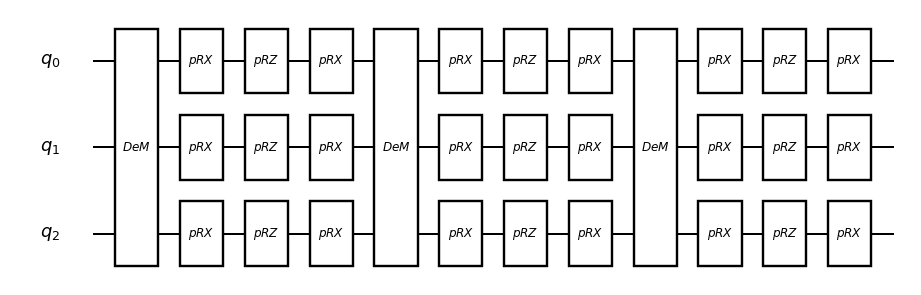

In [111]:
from qulacs import ParametricQuantumCircuit

# Assemble output gate U_out & set initial parameter values
U_out = ParametricQuantumCircuit(nqubit)
for d in range(c_depth):
    U_out.add_gate(time_evol_gate)
    for i in range(nqubit):
        angle = 2.0 * np.pi * np.random.rand()
        U_out.add_parametric_RX_gate(i,angle)
        angle = 2.0 * np.pi * np.random.rand()
        U_out.add_parametric_RZ_gate(i,angle)
        angle = 2.0 * np.pi * np.random.rand()
        U_out.add_parametric_RX_gate(i,angle)

# Get the list of initial values of the parameter theta
parameter_count = U_out.get_parameter_count()
theta_init = [U_out.get_parameter(ind) for ind in range(parameter_count)]
circuit_drawer(U_out,'mpl')


The ```ParametricQuantumCircuit``` class from the qulacs library is used to create a quantum circuit that can have its gate parameters changed.

```U_out = ParametricQuantumCircuit(nqubit)``` creates a new ```ParametricQuantumCircuit``` with ```nqubit``` number of qubits. ```nqubit``` is not defined in the provided code, so it should be defined elsewhere in your program.

The for loop adds gates to the quantum circuit. For each iteration of the loop:

```U_out.add_gate(time_evol_gate)```: This line adds a gate to the circuit. The type of gate is not specified in the provided code, so ```time_evol_gate``` should be defined elsewhere in your program. The inner for loop adds three parametric gates (RX, RZ, and RX again) to each qubit in the circuit. The angle for each gate is randomly generated.
parameter_count = ```U_out.get_parameter_count()``` This line gets the total number of parameters in the circuit. In this case, it should be 3 * nqubit * c_depth because three parametric gates are added to each qubit for each iteration of the outer loop.

```theta_init = [U_out.get_parameter(ind) for ind in range(parameter_count)]```: This line creates a list of the initial values of the parameters in the circuit. This list can be used later to change the parameters of the circuit.

Later, a function named ```set_U_out``` is defined to update parameter $\theta$ in $U(\theta)$ 

In [112]:
# Function that updates parameter theta
def set_U_out(theta):
    global U_out

    parameter_count = U_out.get_parameter_count()

    for i in range(parameter_count):
        U_out.set_parameter(i, theta[i])

## Measurement

In this demostration, the output of the model is the expectation value of 0th qubit's Pauli Z on output state $\ket{\psi_{out}}$, that is:

$y(\theta,x_i)=\left<\psi_\text{out}|Z_0|\psi_\text{out}\right> $

In [113]:
# Create observable Z_0
from qulacs import Observable
obs = Observable(nqubit)
obs.add_operator(2.,'Z 0')
# Set observable as 2*Z。
# The reason for multiplying by 2 here is to expand the value range of the final <Z>.
# In order to cope with any unknown function, this constant also needs to be optimized as one parameter.

### Combine the series of procedures into one function

The procedures up to this point can be combined to define a function that returns the predicted value $y(x_i,\theta)$ of the model from the input $x_i$.

In [114]:
# Function that gives prediction value y(x_i, theta) of the model from input x_i
def qcl_pred(x, U_out):
    state = QuantumState(nqubit)
    state.set_zero_state()

    # Calculate input state
    U_in(x).update_quantum_state(state)

    # Calculate output state
    U_out.update_quantum_state(state)

    # Output of the model
    res = obs.get_expectation_value(state)

    return res

### Calculation of cost function

In [115]:
# Calculate cost function L
def cost_func(theta):
    '''
    theta: ndarray of length c_depth * nqubit * 3
    '''
    # update the parameter theta of U_out
    # global U_out
    set_U_out(theta)

    # calculate basing on data of num_x_train in total
    y_pred = [qcl_pred(x, U_out) for x in x_train]

    # quadratic loss
    L = ((y_pred - y_train)**2).mean()

    return L

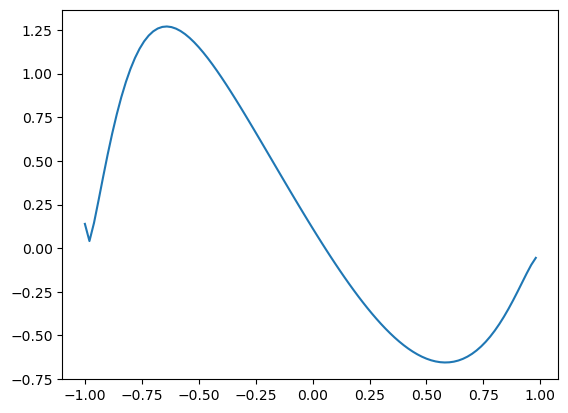

In [116]:
# Figure basing on inital parameter theta
xlist = np.arange(x_min, x_max, 0.02)
y_init = [qcl_pred(x, U_out) for x in xlist]
plt.plot(xlist, y_init)

## Learning (optimization by scipy.optimize.minimize)

Optimization is performed in this case using Nelder-Mead method, which does not need a gradient calculation formula. If 

In [117]:
from scipy.optimize import minimize
print(theta_init)
result = minimize(cost_func, theta_init, method='Nelder-Mead')


[5.427764850661566, 0.7384744305061938, 3.250788804312423, 0.8298083853348984, 4.504162216178747, 2.4885165054447014, 3.5526468790355903, 1.1515811740025799, 0.9101053132841925, 3.066548051650228, 2.234380729504747, 5.908908180814792, 4.808680389933412, 4.703992256264842, 5.6782385905798085, 0.5241586206584286, 3.4695276137516706, 3.67237144886097, 6.04402452012949, 1.8356170478717975, 1.5131718515107218, 0.6301654244416935, 0.10323040725155366, 5.840404945861371, 4.209209802576495, 4.933261240713046, 1.770162461063364]


In [118]:
# Value of cost_function after optimization
result.fun

0.01230640249432221

In [119]:
# Solution of theta by optimization
theta_opt = result.x
print(theta_opt)

[ 4.90489634  1.33895357  2.11627366  0.52906729  2.97904143  2.16132065
  3.45574139  2.7921225  -0.89334662  1.79871137  2.13993038  2.10747279
  6.64540325  2.52706848  7.05239902  0.56728     2.86587926  1.10483863
  7.40937262  0.71865066  1.42265193  0.79266291  0.14990173  9.91225027
  9.80669305  5.02801677  1.6399598 ]


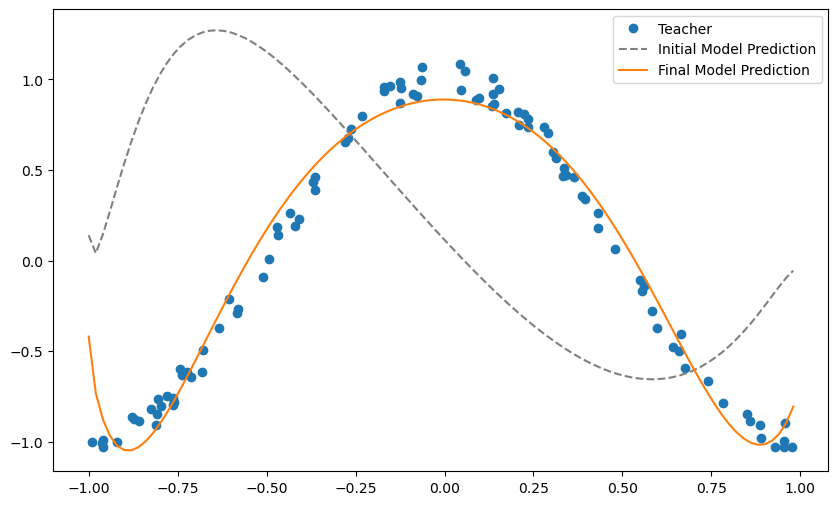

In [120]:
# Insert optimized theta into U_out
set_U_out(theta_opt)
# Plot
plt.figure(figsize=(10, 6))

xlist = np.arange(x_min, x_max, 0.02)

# teacher data
plt.plot(x_train, y_train, "o", label='Teacher')

# Figure basing on inital parameter theta
plt.plot(xlist, y_init, '--', label='Initial Model Prediction', c='gray')

# Prediction of the model
y_pred = np.array([qcl_pred(x, U_out) for x in xlist])
plt.plot(xlist, y_pred, label='Final Model Prediction')

plt.legend()
plt.show()